# Density Estimation

Density estimation walks the line between unsupervised learning, feature engineering, and data modeling. Some of the most popular and useful density estimation techniques are mixture models such as Gaussian Mixtures, and neighbor-based approaches such as the kernel density estimate.

**Density estimator is an algorithm which takes a D-dimensional dataset and produces an estimate of the D-dimensional probability distribution which that data is drawn from.** The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions. Kernel density estimation (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component per point, resulting in an essentially non-parametric estimator of density.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')

## 1. Histograms

For one dimensional data, you are probably already familiar with the simplest density estimator: the histogram. A histogram divides the sample space into a number of bins, counts the number of points that fall in each bin, and then approximate the density by the fraction of total training data points.

The histogram requires two “parameters” to be defined: bin width and starting position of the first bin.

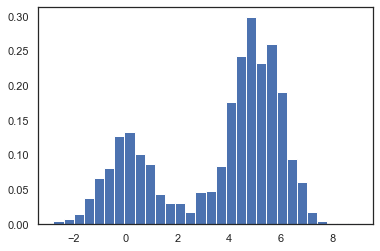

In [35]:
np.random.seed(1)
n = 1000
x = np.concatenate((np.random.normal(0, 1, int(0.3 * n)), np.random.normal(5, 1, int(0.7 * n))))
x_plot = np.linspace(-5, 10, 1000)
plt.hist(x, bins=30, density=True)
plt.show()

By specifying the `density` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density. Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts. This normalization is chosen so that the total area under the histogram is equal to 1.

However, the histogram is a very simple form of density estimation, but has several drawbacks.

* The density estimator depends on the starting position of the bins
* Discontinuities make it very difficult due to the underlying density
* The curse of dimensionality that most of the bins would be closely empty

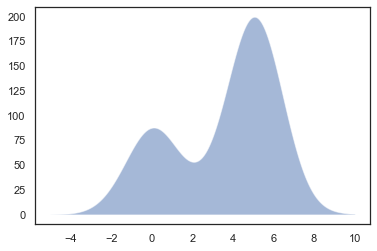

In [36]:
from scipy.stats import norm

density = sum(norm(xi).pdf(x_plot) for xi in x)
plt.fill_between(x_plot, density, alpha=0.5)
plt.show()

## 2. Kernel Density Estimation

The probability that a vector 𝑥, drawn from a distribution 𝑝(𝑥), where `v` volume surrounding x, `K` # of sample inside V, `N` total # of sample.  

$$ p(x) \simeq \frac{K}{NV}$$

When applying this result to practical density estimation problems, two basic approaches can be adopted. It can be shown that both `KNN` and `KDE` converge to the true probability density as 𝑁 $\rightarrow \infty$, provided that `𝑉` shrinks with `𝑁`, and that `K` grows with `𝑁` appropriately.

* We can fix `𝑉` and determine `K` from the data. This leads to kernel density estimation (KDE)
* We can fix `K` and determine `K` from the data. This gives rise to the knearest-neighbor (kNN) approach

The non-parameters of kernel density estimation are the kernel, which specifies the shape of the distribution placed at each point, and the kernel bandwidth. **The expectation of $P_{KDE}(𝑥)$ is a convolution of the true density $𝑝(𝑥)$ with the kernel function.** Assumed that vectors $X$ are drawn independently from the true density $𝑝(𝑥)$.

* The kernel function determines the shape of the bumps
* The parameter `𝒉`, also called the smoothing parameter or bandwidth, determines their width

### 2.1. Bandwidth Selection

The bandwidth here acts as a smoothing parameter, controlling the tradeoff between bias and variance in the result. A large bandwidth leads to a very smooth (i.e. high-bias) density distribution. A small bandwidth leads to an unsmooth (i.e. high-variance) density distribution.

* A large ℎ will over-smooth the DE and mask the structure of the data
* A small ℎ will yield a DE that is spiky and very hard to interpret

We would like to find a value of `𝒉` that minimizes the error between the estimated density and the true density.
A natural measure is the MSE at the estimation point 𝑥, defined by:

$$E[(P_{KDE} - P)^2] = E[P_{KDE} - P]^2 + var(P_{KDE})$$

This expression is an example of the bias-variance tradeoff: the bias can be reduced at the expense of the variance, and vice versa.

* A large bandwidth will reduce the differences among the estimates of $P_{KDE}(x)$ for different data sets (the variance), but it will increase the bias of $P_{KDE}(x)$ with respect to the true density $P(x)$
* A small bandwidth will reduce the bias of $P_{KDE}(x)$ , at the expense of a larger variance in the estimates $P_{KDE}(x)$


## 3. General Application

Kernel density estimation in scikit-learn is implemented in the sklearn.neighbors.KernelDensity estimator, which uses the Ball Tree or KD Tree for efficient queries. Though the above example uses a 1D data set for simplicity, kernel density estimation can be performed in any number of dimensions.

In [37]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(x.reshape((-1,1)))

# score_samples returns the log of the probability density
log_dens = kde.score_samples(x_plot.reshape((-1,1)))
log_dens[:10]

array([-11.49181414, -11.42856339, -11.36565324, -11.30308283,
       -11.24085125, -11.17895761, -11.11740097, -11.05618041,
       -10.99529496, -10.93474368])

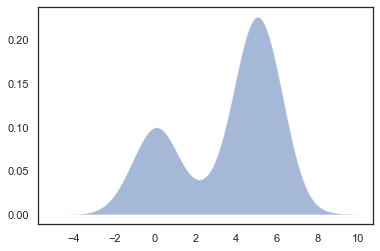

In [39]:
plt.fill_between(x_plot, np.exp(log_dens), alpha=0.5)
plt.show()

### Maximum likelihood cross-validation

In machine learning contexts, we've seen that such hyperparameter tuning often is done empirically via a cross-validation approach. With this in mind, the `KernelDensity` estimator in Scikit-Learn is designed such that it can be used directly within the Scikit-Learn's standard grid search tools. Here we will use `GridSearchCV` to optimize the bandwidth for the preceding dataset. Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial.

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
grid.fit(x.reshape((-1,1)))

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.305385...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

In [41]:
grid.best_params_

{'bandwidth': 0.35111917342151316}

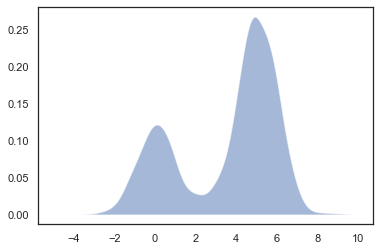

In [43]:
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=grid.best_params_['bandwidth'], kernel='gaussian')
kde.fit(x.reshape((-1,1)))

# score_samples returns the log of the probability density
log_dens = kde.score_samples(x_plot.reshape((-1,1)))

plt.fill_between(x_plot, np.exp(log_dens), alpha=0.5)
plt.show()